In [1]:
import torch.nn as nn
import functools
import torch
import numpy as np
from matplotlib import pyplot as plt
import numba_scipy
import gc
import os
from utils import save_checkpoint_withEval as save_checkpoint
from utils import restore_checkpoint_withEval as restore_checkpoint
import datasets
import tensorflow as tf
from torch.utils.cpp_extension import load
from models import ncsnpp
from configs.vp import cifar10_ncsnpp_continuous as configLoader
from models import utils as mutils
from models.ema import ExponentialMovingAverage

No ROCm runtime is found, using ROCM_HOME='/opt/rocm-5.4.3'


In [2]:
softplus = nn.functional.softplus

### Loading the ML model from Song et al.

In [3]:
config =  configLoader.get_config()
config.training.snapshot_freq_for_preemption=1000
config.training.snapshot_freq=50000
config.training.log_freq=5
config.data.dataset='CELEBA'
config.data.image_size=64

### Specify observation times

In [4]:
data = np.load('forwardSolution.npz', allow_pickle=True)
cumSolArray=data['cumSolArray']
brTable=data['brTable']
observationTimes=data['observationTimes']

In [5]:
tEnd = observationTimes[-1]
T = len(observationTimes)
observationTimes = np.hstack((0, observationTimes))

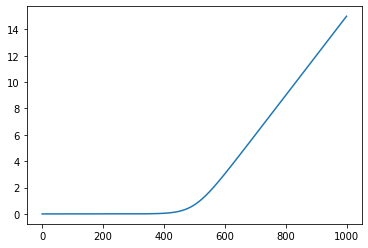

In [6]:
plt.plot(observationTimes)

### Load the trained model

In [8]:
score_model = mutils.create_model(config)
score_fn = mutils.get_model_fn(score_model, train=True)
optimizer = torch.optim.Adam(score_model.parameters(),lr=config.optim.lr) 
ema = ExponentialMovingAverage(score_model.parameters(), decay=config.model.ema_rate)
state = dict(optimizer=optimizer, model=score_model, ema=ema, lossHistory=[], step=0)

workdir = 'blackout-celebA64'

checkpoint_dir = os.path.join(workdir, "checkpoints")
checkpoint_meta_dir = os.path.join(workdir, "checkpoints-meta", "checkpoint.pth")
tf.io.gfile.makedirs(checkpoint_dir)
tf.io.gfile.makedirs(os.path.dirname(checkpoint_meta_dir))

state = restore_checkpoint(checkpoint_meta_dir, state, config.device)

initial_step = int(state['step'])
lossHistory = state['lossHistory']
evalLossHistory = state['evalLossHistory']
ema.copy_to(score_model.parameters())

### Visualize train/test loss

In [9]:
def emaFunc(x, r):
    
    output = np.zeros_like(x)
    
    output[0] = x[0]
    
    for i in range(1, len(x)):
        
        output[i] = (1.0-r)*output[i-1] + (r)*x[i]
        
    return output

Text(0.5, 1.0, 'Iteration=1471')

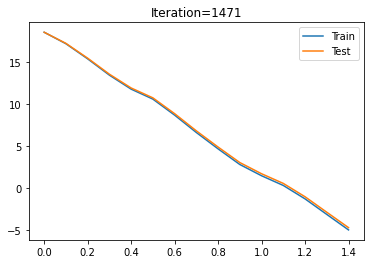

In [11]:
fig = plt.figure()
onset = 0_000
samplingRate = 100
emaRate = 0.01
plt.plot(onset/1000+1./1000*samplingRate*np.arange(len(lossHistory[onset::samplingRate][:])), np.array(emaFunc(lossHistory[onset::samplingRate][:],emaRate)), label='Train')
plt.plot(onset/1000+1./1000*samplingRate*np.arange(len(evalLossHistory[onset//samplingRate:])), np.array(emaFunc(evalLossHistory[onset//samplingRate:], emaRate)), label='Test')
plt.legend(loc='best')
plt.title(f'Iteration={len(lossHistory)}')


### Generating samples

In [12]:
from scipy.stats import binom,poisson

from time import time

In [13]:
generation='binomial'

In [15]:
observationTimesGPU = torch.from_numpy(observationTimes[1:]).to(config.device)

targetN = 50_000
ensN = 512
skipped=1

torch.cuda.set_device(config.device)
batchN = int(np.ceil(targetN/ensN))
state = torch.cuda.FloatTensor(ensN*batchN, 3,64,64).zero_()
identity = torch.from_numpy(np.ones((ensN,))).long().to(config.device)
u = torch.cuda.FloatTensor(ensN,3,64,64,256).uniform_()

n_ma = np.zeros((ensN,3,64,64,256))

summary = []

with torch.no_grad():
    
    for jj in range(batchN):
    
        t0 = time()
        
        for i in range(T-1, -1, -skipped):

            if np.mod(i+1,50)==0:
                
                print(f'reverse pass, tIndex={i}, t={observationTimes[i]}, {torch.max(state[jj*ensN:(jj+1)*ensN,:,:,:]).detach().cpu().numpy()}')
            
            t = observationTimes[i+1]
            s = observationTimes[i+1-skipped]

            pt = np.exp(-t)
            ps = np.exp(-s)
            
            width = 1.0
            mean_v = 255.0/2*pt
            
            ind = i*identity
            
            
            dn = softplus(score_fn((state[jj*ensN:(jj+1)*ensN,:,:,:]-mean_v)/width, ind))
            
            # Binomial bride sampling, GPU implementation
            
            if generation=='binomial':
                
                dnNP = np.clip(np.round(dn.detach().cpu().numpy()).astype('int'), 0, 255-np.round(state[jj*ensN:(jj+1)*ensN,:,:,:].detach().cpu().numpy())).astype('int')

                pp = (np.exp(-s) - np.exp(-t))/(1-np.exp(-t))

                drawNP = binom(dnNP, pp).rvs() 
                
            elif generation=='poisson':
                
                drawNP = poisson(dn.detach().cpu().numpy() * (ps-pt)/(1-pt)).rvs() 
                
            else:
                
                raise NotImplementedError(f'Sampling method is not implemented.')
            
            state[jj*ensN:(jj+1)*ensN,:,:,:] = (state[jj*ensN:(jj+1)*ensN,:,:,:] + torch.from_numpy(drawNP).to(config.device)).clip(0,255)
    
    
        t1 = time()
        print( f'round {jj}, time elapsed={t1-t0}')            

        totalState = state.detach().cpu().numpy()
        generatedFileName=f'blackout-MNIST-samples-uint8-{targetN}'
        np.savez(generatedFileName, np.transpose(totalState[:targetN, :, :, :], (0,2,3,1)).astype('uint8'))
generatedFileName += '.npz'
print('saved:  '+ generatedFileName)

reverse pass, tIndex=999, t=14.969969979907875, 0.0
reverse pass, tIndex=949, t=13.468469608670452, 1.0


KeyboardInterrupt: 